### Load data

Choose that dataset to load. We have prepared 2 different datasets, downloaded and converted from the competition:
* wbg-fal10: dataset_01 ([ITC2019 description](https://www.itc2019.org/instances/status/5b59b12884ed6a262b1ce9d3))
* pu-cs-fal07: dataset_04 ([ITC2019 description](https://www.itc2019.org/instances/status/5b59ebf984ed6a262b1ce9dc))

Choose between datasets by adjusting the command `import dataset_0x as dataset`

In [1]:
from docplex.mp.model import Model
import time
import dataset_01 as dataset

solution_filename = 'Solutions/sol_01_mp.py'
progress_filename = 'Progress/log_01_mp.txt'

rooms = dataset.rooms
courses = dataset.courses
students = dataset.students
constraints = dataset.constraints

List of supporting tables:
* `classes`: 150 classes with details
* `classes_id`: ids from 1 to 150
* `rooms_id`: ids from 1 to 7
* `students_id`: ids from 1 to 19
* `student_subparts`: pairs of 1 student & 1 subpart that he/she must attend (the subpart is a list of classes_id)
* `student_classes`: pairs of 1 student & the list of all classes that he/she might attend (flattened from above subpart) -> 19 pairs

In [2]:
rooms_id = [r['id'] for r in rooms]
students_id = [s['id'] for s in students]

# class-time pairs
classes = []
for course in courses:
    for subpart in course['subpart']:
        for c in subpart['class']:
            classes.append(c)
classes_id = [c['id'] for c in classes]

# student-subpart pairs
student_subparts = []
for s in students_id:
    for i in students[s-1]['course']:
        for subpart in courses[i-1]['subpart']:
            student_subparts.append([s,[c['id'] for c in subpart['class']]]) 

# student-classes pairs
student_classes = []
for s in students_id:
    student_classes.append([s, []])
    class_list = student_classes[-1][1]
    for i in students[s-1]['course']:
        for subpart in courses[i-1]['subpart']:
            for c in subpart['class']:
                class_list.append(c['id'])

# pairs of classes with SameAttendee constraint
SA_pairs=[]
for ct in constraints:
    if ct['type']=='SameAttendees':
        for i1 in range(len(ct['class'])):
            for i2 in range(i1+1, len(ct['class'])):
                c1, c2 = ct['class'][i1], ct['class'][i2]
                SA_pairs.append((c1,c2))

### support functions:

In [3]:
def clash(time1, time2):
    clash_days = bool(sum([int(a) & int(b) for a,b in zip(time1['days'], time2['days'])]))
    clash_weeks = bool(sum([int(a) & int(b) for a,b in zip(time1['weeks'], time2['weeks'])]))
    clash_time1 = time1['start'] < time2['start'] + time2['length']
    clash_time2 = time1['start'] + time1['length'] > time2['start']
    return clash_days and clash_weeks and clash_time1 and clash_time2

# Modeling

### Decision Variables

In [4]:
m = Model('model1')

# x = 1 if the class c takes place at time t, 0 otherwise
x = m.binary_var_dict([(c,t) 
                       for c in classes_id 
                       for t in range(len(classes[c-1]['time']))], name= 'x')

# y = 1 if the class c takes place at room r, 0 otherwise
y = m.binary_var_dict([(c,r) 
                       for c in classes_id 
                       for r in range(len(classes[c-1]['room']))], name= 'y')

# z = 1 if the student s takes class c, 0 otherwise
z = m.binary_var_dict([(s,c) 
                       for s in students_id 
                       for c in student_classes[s-1][1]], name= 'z')

### Objective functions
(skip if only search for feasible solution)

### Constraints

In [5]:
# Every class must be assigned a time
m.add_constraints(m.sum(x[c,t] for t in range(len(classes[c-1]['time']))) == 1 
                  for c in classes_id)

# Every class must be assigned a room, where applicable
m.add_constraints(m.sum(y[c,r] for r in range(len(classes[c-1]['room']))) == 1 
                  for c in classes_id)

# Every student must attend exactly one class for each subpart that he/she must attend
m.add_constraints(m.sum(z[s,c] for c in subpart) == 1 
                  for s, subpart in student_subparts)

# For two classes with a parent-child relationship, if a class is assigned to a student
# then the parent class must also be assigned
m.add_constraints(z[s,c] <= z[s,classes[c-1]['parent']] 
                  for s in students_id 
                  for c in student_classes[s-1][1] if classes[c-1].get('parent', 0));

# The capacity of each class in terms of the number of students must be satisfed
m.add_constraints(m.sum(z[s,c] for s in students_id if c in student_classes[s-1][1]) <= classes[c-1]['limit'] 
                  for c in classes_id);

# A room cannot be used when it is unavailable
# there are no clashes in this test set
for c in classes_id:
    for t in range(len(classes[c-1]['time'])):
        for r in range(len(classes[c-1]['room'])):
            ctime = classes[c-1]['time'][t]
            croom = rooms[classes[c-1]['room'][r]['id'] - 1]
            penalty = classes[c-1]['room'][r]['penalty']
            for room_uat in croom['unavailable']:
                if clash(ctime, room_uat):
                    m.add_constraint(x[c,t] + y[c,r] <= 1)

# Any hard distribution constraints must be satisfied
# in this instance refers to the same attendee requirement 
for c1, c2 in SA_pairs:
    for t1 in range(len(classes[c1-1]['time'])):
        for t2 in range(len(classes[c2-1]['time'])):
            time1=classes[c1-1]['time'][t1]
            time2=classes[c2-1]['time'][t2]
            if clash(time1, time2):
                m.add_constraint(x[c1,t1] + x[c2,t2] <= 1) 

* Two class cannot be at the same time and in the same room (H8) (~3 minutes)

In [6]:
# Two class cannot be at the same time and in the same room
# Long time to run
for i1 in range(len(classes_id)):
    for i2 in range(i1+1, len(classes_id)):
        c1, c2 = classes_id[i1], classes_id[i2]
            
        for t1 in range(len(classes[c1-1]['time'])):
            for t2 in range(len(classes[c2-1]['time'])):
                time1=classes[c1-1]['time'][t1]
                time2=classes[c2-1]['time'][t2]
                if clash(time1, time2):

                    for r1 in range(len(classes[c1-1]['room'])):
                        for r2 in range(len(classes[c2-1]['room'])):
                            r1_id=classes[c1-1]['room'][r1]['id']
                            r2_id=classes[c2-1]['room'][r2]['id']
                            if r1_id==r2_id:
                                m.add_constraint(x[c1,t1] + x[c2,t2] + y[c1,r1] + y[c2,r2] <= 3)   

In [7]:
print(m.get_statistics())

 - number of variables: 6272
   - binary=6272, integer=0, continuous=0
 - number of constraints: 601751
   - linear=601751


### support functions:

In [8]:
def extract_time(class_id, x_sol):
    # output: time dict
    for t in range(len(x_sol[class_id-1]['time'])):
        if x_sol[class_id-1]['time'][t]==1:
            return classes[class_id-1]['time'][t]

def extract_room(class_id, y_sol):
    # output: room dict{'id', 'penalty'}
    for r in range(len(y_sol[class_id-1]['room'])):
        if y_sol[class_id-1]['room'][r]==1:
            return classes[class_id-1]['room'][r]

def extract_xyz(sol):
    '''
    Input: Solution object (docplex.mp.solution.SolveSolution)
    Output: x, y, z in python list format
    '''
    
    # initialize x,y,z
    x_sol = []
    for c in classes_id:
        x_sol.append({'id':c})
        x_sol[-1]['time'] = [0]*len(classes[c-1]['time'])    

    y_sol = []
    for c in classes_id:
        y_sol.append({'id':c})
        y_sol[-1]['room'] = [0]*len(classes[c-1]['room'])      

    z_sol = [[0]*len(classes_id) for _ in range(len(students_id))]
    
    # extract data
    content = str(sol).split('\n')
    for line in content:
        if len(line)==0 or line[0] not in ('x', 'y', 'z'):
            continue
        var, idx1, idx2 = line[:-2].split('_')
        if var=='x':
            x_sol[int(idx1)-1]['time'][int(idx2)] = 1
        elif var=='y':
            y_sol[int(idx1)-1]['room'][int(idx2)] = 1
        elif var=='z':
            z_sol[int(idx1)-1][int(idx2)-1] = 1
    
    return x_sol, y_sol, z_sol

In [9]:
def check_solution(sol):
    '''
    Input: Solution object (docplex.mp.solution.SolveSolution)
    Function: Announce constraints violated by the solution
    '''
    print('---no output if all constraints passed---')
    x_sol, y_sol, z_sol = extract_xyz(sol)
    
    # (1) check x
    for i in x_sol:
        if sum(i['time']) != 1:
            print('Constraint (1) violated!')
            break

    # (2) check y
    for i in y_sol:
        if sum(i['room']) != 1:
            print('Constraint (2) violated!')
            break

    # (3) check z
    for s, class_list in student_subparts:
        if sum([z_sol[s-1][c-1] for c in class_list]) != 1:
            print('Constraint (3) violated!')
            break

    # (4) check parent-child relationship
    for c in classes:
        c_parent = c.get('parent', 0)
        if c_parent:
            for s in students_id:
                # print out details if there is a constraint violation:
                if z_sol[s-1][c['id']-1] > z_sol[s-1][c_parent-1]:
                    print('Constraint (4) violated!')
                    break

    # (5) check class limit
    for c in classes:
        # print out details if there is a constraint violation:
        if sum([z_sol[i][c['id']-1] for i in range(len(z_sol))]) > c['limit']:
            print('Constraint (5) violated!')
            break
            
    # (6) check room unavailable time
    for c in classes_id:
        ctime = extract_time(c, x_sol)
        room_id = extract_room(c, y_sol)['id']
        for room_uat in rooms[room_id-1]['unavailable']:
            if clash(ctime, room_uat):
                print('Constraint (6) violated!')
                break

    # (7) check SameAttendees
    for c1, c2 in SA_pairs:
        time1 = extract_time(c1, x_sol)
        time2 = extract_time(c2, x_sol)
        if clash(time1, time2):
            print('Constraint (7) violated!')
            break

    # (8) check if 2 classes clash room-time constraint
    for i1 in range(len(classes_id)):
        for i2 in range(i1+1, len(classes_id)):
            c1, c2 = classes_id[i1], classes_id[i2]
            time1 = extract_time(c1, x_sol)
            time2 = extract_time(c2, x_sol)
            room1 = extract_room(c1, y_sol)
            room2 = extract_room(c2, y_sol)
            # print out details if there is a constraint violation:
            if clash(time1, time2) and room1==room2:
                print('Constraint (8) violated!')
                break

In [10]:
def objective(sol):
    x_sol, y_sol, z_sol = extract_xyz(sol)
    
    # calculate objective value
    time_penalty = 0
    for c in classes_id:
        for t in range(len(classes[c-1]['time'])):
            if x_sol[c-1]['time'][t] == 1:
                time_penalty += classes[c-1]['time'][t]['penalty']
    
    room_penalty = 0
    for c in classes_id:
        for r in range(len(classes[c-1]['room'])):
            if y_sol[c-1]['room'][r] == 1:
                room_penalty += classes[c-1]['room'][r]['penalty']

    return time_penalty, room_penalty

### Solver
* without objective: runtime = 5.29 s

In [11]:
it = 0
executionTime = 0
obj = []
exec_time = []
sol_prev = None

while True:
    startTime = time.time()
    
    m.set_time_limit(30)
    sol = m.solve(log_output=False)

    executionTime = (time.time() - startTime)
    print('Iteration: ', it, ', Execution time: ', str(executionTime))
    
    # save the progress
    if sol:
        sol_prev = sol
    sol_time, sol_room = objective(sol_prev)
    sol_penalty = sol_time + sol_room
    print('Time penalty: ', sol_time)
    print('Room penalty: ', sol_room)
    print('Total penalty: ', sol_penalty)
    obj.append([sol_time, sol_room, sol_penalty])
    exec_time.append(executionTime)
    
    filename = progress_filename
    file = open(filename, 'w')
    file.write(str(obj) + '\n' + str(exec_time))
    file.close()
    
    # stopping criteria
    #if executionTime > 30 or it > 50 or sol_penalty < 0.15 * obj[0][2]:
    if executionTime > 30 or it > 50:
        print('Stopping criteria met')
        break
    
    # update model constraints
    time_penalty = m.sum(x[c,t]*classes[c-1]['time'][t]['penalty'] 
                         for c in classes_id for t in range(len(classes[c-1]['time'])))
    room_penalty = m.sum(y[c,r]*classes[c-1]['room'][r]['penalty'] 
                         for c in classes_id for r in range(len(classes[c-1]['room'])))
    m.add_constraint(time_penalty + room_penalty <= sol_penalty-1)
    
    it += 1

Iteration:  0 , Execution time:  17.570014715194702
Time penalty:  144
Room penalty:  38
Total penalty:  182
Iteration:  1 , Execution time:  17.280726671218872
Time penalty:  128
Room penalty:  36
Total penalty:  164
Iteration:  2 , Execution time:  16.171014070510864
Time penalty:  120
Room penalty:  33
Total penalty:  153
Iteration:  3 , Execution time:  16.765631198883057
Time penalty:  112
Room penalty:  33
Total penalty:  145
Iteration:  4 , Execution time:  16.919880867004395
Time penalty:  96
Room penalty:  37
Total penalty:  133
Iteration:  5 , Execution time:  20.267347812652588
Time penalty:  96
Room penalty:  28
Total penalty:  124
Iteration:  6 , Execution time:  19.42621684074402
Time penalty:  88
Room penalty:  28
Total penalty:  116
Iteration:  7 , Execution time:  17.807680368423462
Time penalty:  16
Room penalty:  30
Total penalty:  46
Iteration:  8 , Execution time:  18.407712697982788
Time penalty:  0
Room penalty:  30
Total penalty:  30
Iteration:  9 , Execution ti

* save solution to text

In [15]:
filename = solution_filename

file = open(filename, 'w')
file.write(str(sol_prev))
file.close()

In [16]:
check_solution(sol_prev)

---no output if all constraints passed---


* plot objective through time:

Total runtime: 338.4067 seconds
Objective value: 17


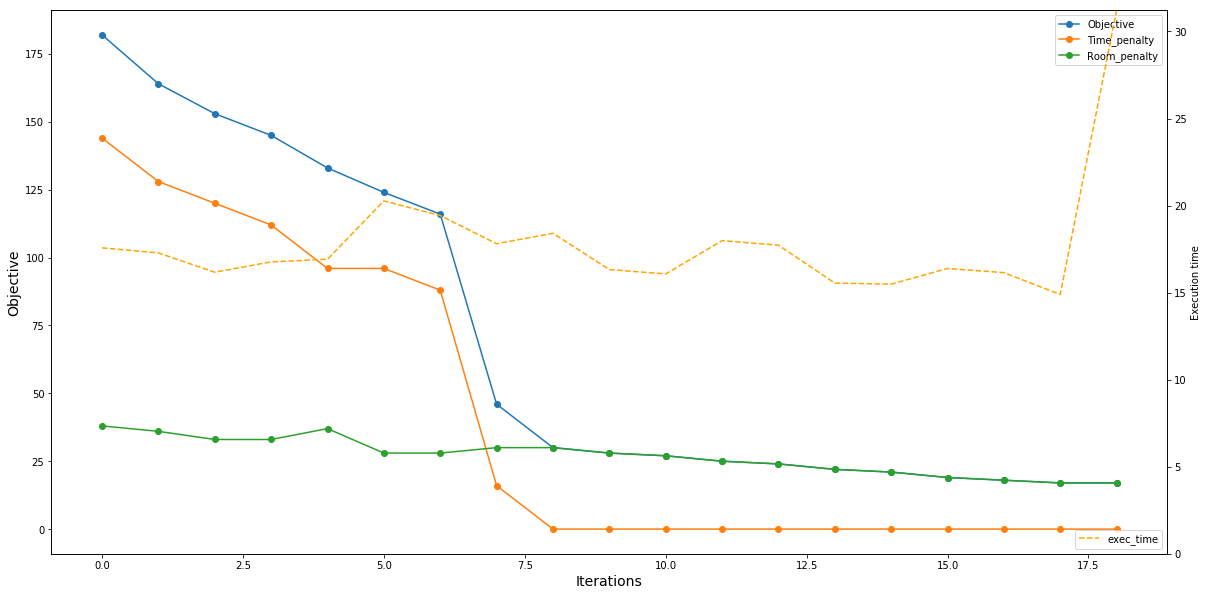

In [17]:
import matplotlib.pyplot as plt
import json

fileObj=open(progress_filename,"r")
content=fileObj.readlines()
obj = json.loads(content[0][:-1])
exec_time = json.loads(content[1])

print('Total runtime: {0:.4f} seconds'.format(sum(exec_time)))
print('Objective value: {0}'.format(obj[-1][-1]))

plt.figure(figsize=(20,10))
ax = plt.gca()
ax2 = ax.twinx()

ax.plot([i for i in range(len(obj))], [val[2] for val in obj], marker='o', label='Objective')
ax.plot([i for i in range(len(obj))], [val[0] for val in obj], marker='o', label='Time_penalty')
ax.plot([i for i in range(len(obj))], [val[1] for val in obj], marker='o', label='Room_penalty')
ax.set_ylabel('Objective', fontsize=14)
ax.set_xlabel('Iterations', fontsize=14)

ax2.plot([i for i in range(len(obj))], [val for val in exec_time], linestyle='dashed', color='orange', label='exec_time')
ax2.set_ylabel('Execution time')
ax2.set_ylim(0, max(exec_time))

ax.legend()
ax2.legend(loc='lower right')
plt.show();